<a href="https://colab.research.google.com/github/MISAKITSUBASA/selfLearningML/blob/main/tut05_f21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision

import numpy as np
from tqdm.notebook import tqdm
print(torch.__version__)

1.9.0+cu111


In [ ]:
!pip install ipdb
!pip install torchviz
!apt install graphviz
import ipdb
from torchviz import make_dot

     |████████████████████████████████| 788 kB 5.4 MB/s 
     |████████████████████████████████| 370 kB 42.9 MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.9-py3-none-any.whl size=11648 sha256=ba1c14c02cb36ae0ef6e217f0dbbe3703f571d40b4f0c3b4ebc623fd67b0f1d2
  Stored in directory: /root/.cache/pip/wheels/65/cd/cc/aaf92acae337a28fdd2aa4d632196a59745c8c39f76eaeed01
Successfully built ipdb
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=5dbf105422c742632f73aa93cc9259e89bcd35b62bee7417e6dd766c63cef730
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


# PyTorch: The Basics

PyTorch allows you to dynamically define computational graphs. This is done by operating on PyTorch Tensor objects

Here is an example, where we work with the function

$$f(x) = x^2 + 2x + 6$$

Note how there is nothing special about this function in terms of PyTorch specific syntax. I.e. you could apply this to any object that implements the `**`, `*` and `+` operators.

In [ ]:
def f(x):
    return x ** 2 + 2 * x + 6

Now let's compute $$\frac{d}{dx}\bigg\rvert_{x=4} f(x) = 2(4) + 2 = 10$$

In [ ]:
np_x = np.array([4.0])
x = torch.from_numpy(np_x)
y = f(x)

In [ ]:
y.backward()

RuntimeError: ignored

In [ ]:
x.grad

What went wrong in the above call to `backward` was that `x` did not have its `requires_grad` property set to true. By default, during the forward pass, i.e. when evaluating f(x), an operation is recorded in the backward graph, only if at least one of its input tensors requires a gradient.

Let's set `x.requires_grad = True` and redo the above

In [ ]:
np_x = np.array([4.0])
x = torch.from_numpy(np_x).requires_grad_(True)
y = f(x)

In [ ]:
y.backward()

In [ ]:
x.grad

tensor([10.], dtype=torch.float64)

We can visualize the computation graph by calling the `make_dot` function from `torchviz`. There are 

* 2 Addition Operations
* 1 Power Operation
* 1 Multiply Operation
* 1 Accumulate Operation



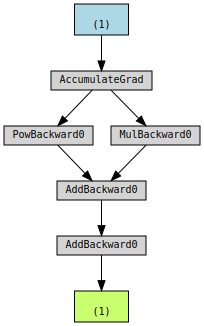

In [ ]:
make_dot(y)

If we instead evaluate $$\frac{d}{dx}\bigg\rvert_{x=5} f(x) = 2(5) + 2 = 12$$

In [ ]:
np_x = np.array([5.0])
x = torch.from_numpy(np_x).requires_grad_(True)
y = f(x)

In [ ]:
y.backward()

In [ ]:
x.grad

tensor([12.], dtype=torch.float64)

We still get the right answer.

Unlike Tensorflow, we can define the graph on the fly. That is why it is more convenient to define a function in Python: we call the function as part of constructing the graph.



# Linear Classification with Pytorch

Let's now create a simple linear function for classifiying MNIST digits. Material is lifted from: https://github.com/fastai/fastai_old/blob/master/dev_nb/001a_nn_basics.ipynb

In [ ]:
import matplotlib.pyplot as plt
import math
%matplotlib inline

First we define/download the data. Note that when working with Google colab, whatever data you may have downloaded will eventually be deleted, as will the variables and functions in the runtime.

In [ ]:
from torchvision import datasets, transforms

mnist_train = datasets.MNIST('data', train=True, download=True,
                       transform=transforms.ToTensor())

mnist_test = datasets.MNIST('../data', train=False, download=True, transform=
                            transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
print(mnist_train)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


We can easily visualize the images and their corresponding label as below. See how index 0 for a given sample corresponds to the image, and index 1 is the label.

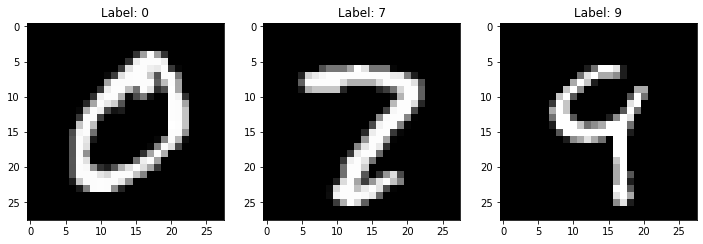

In [ ]:
indices = [1, 12000, 344]

fig = plt.figure(figsize=(len(indices) * 4, 4))

for i, index in enumerate(indices):
    ax = fig.add_subplot(1, len(indices), i + 1)
    example = mnist_train[index]
    ax.imshow(example[0].reshape(28, 28), cmap=plt.cm.gray)
    ax.set_title("Label: {}".format(example[1]))

Pytorch's DataLoader is responsible for managing batches. You can create a DataLoader from any Dataset. DataLoader makes it easier to iterate over batches (it can shuffle and give you the next batch).

A drawback of having a `Dataset` wrapped with a `DataLoader` is that the `DataLoader` does not allow indexing. That's why if we want to get a batch from a `DataLoader` without actually iterating over it as part of a loop, we have to convert it to an `Iterator`, and then called the `next` method.

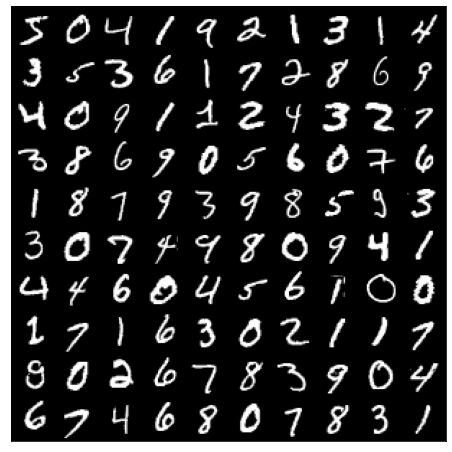

In [ ]:
from torch.utils.data import DataLoader
train_dl = DataLoader(mnist_train, batch_size=100, shuffle=False)

dataiter = iter(train_dl)
images, labels = dataiter.next()
viz = torchvision.utils.make_grid(images, nrow=10, padding = 2).numpy()
fig, ax = plt.subplots(figsize= (8,8))
ax.imshow(np.transpose(viz, (1,2,0)))
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Thanks to PyTorch's ability to calculate gradients automatically, we can use any standard Python function (or callable object) as a model! So let's just write a plain matrix multiplication and broadcasted addition to create a simple linear model. We also need an activation function, so we'll write log_softmax and use it. Remember: although PyTorch provides lots of pre-written loss functions, activation functions, and so forth, you can easily write your own using plain python. PyTorch will even create fast GPU or vectorized CPU code for your function automatically.


## Model Definition

In [ ]:
def log_softmax(x): 
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb, weights, bias):      
    return log_softmax(xb @ weights + bias)

def nll(input, target): 
    # input (prediction) shape = (batch_size, 10)
    # target shape = (batch_size,)
    # input[range(batch_size), target] shape = (batch_size,)
    return -input[range(target.shape[0]), target].mean()

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds==yb).float().mean()

def num_correct(out, yb):
    preds = torch.argmax(out, dim=1)
    return torch.sum(preds == yb)

loss_func = nll

In the above, the '@' is syntactic sugar for the matrix multiply operation. The naming of the above functions is a bit misleading. Recall that the cross entropy loss, or negative log-likelihood, is defined as 

$$-\sum_{j=1}^{K}y_{j}\mathrm{log} \: p_j$$ 

where $y$ is a one-hot encoded vector containing an entry of 1 at the index of the target class, and 0s elsewhere, and $p$ is a vector of probabilities predicted by our model for each class. In the Python definition of `nll` above, the log has been removed since we are already passing in log-probabilities because we're using the activation function `log_softmax`, so it's written as 

$$-\sum_{j=1}^{K}y_{j} p'_j$$ 



We will call our function on one batch of data (in this case, 128 images). This is one forward pass. Note that our predictions won't be any better than random at this stage, since we start with random weights.

In [ ]:
def eval_performance(dl, weights, bias):
    total_samples = 0
    total_correct = 0

    for xb, yb in dl:
        xb = xb.view(xb.size(0), -1)

        preds = model(xb, weights, bias)
        correct = num_correct(preds, yb)

        total_correct += correct
        total_samples += len(yb)

    return total_correct / float(total_samples)

## Training

In [ ]:
lr = 0.1
epochs = 5
bs = 128

in_shape = 784
out_shape = 10

train_dl = DataLoader(mnist_train, batch_size=bs)
test_dl = DataLoader(mnist_test, batch_size=bs)

# Initialize weights
weights = torch.randn(in_shape, out_shape) / math.sqrt(in_shape)
weights.requires_grad_()
bias = torch.zeros(out_shape, requires_grad=True)


for epoch in range(epochs):
    for i, (xb, yb) in enumerate(train_dl):
    
        xb = xb.view(xb.size(0), -1)
            
        # Forward pass    
        pred = model(xb, weights, bias)
        loss = loss_func(pred, yb)

        # Backward pass
        loss.backward()
        with torch.no_grad():   # temporarily sets all the requires_grad flags to False
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
            
    train_acc = eval_performance(train_dl, weights, bias)
    test_acc = eval_performance(test_dl, weights, bias)
    print("Epoch: {} | Train Acc: {} | Test Acc: {}".format(epoch + 1, train_acc,
                                                            test_acc))
     


Epoch: 1 | Train Acc: 0.8884333372116089 | Test Acc: 0.8962000012397766
Epoch: 2 | Train Acc: 0.9008499979972839 | Test Acc: 0.90829998254776
Epoch: 3 | Train Acc: 0.906416654586792 | Test Acc: 0.9122999906539917
Epoch: 4 | Train Acc: 0.9103500247001648 | Test Acc: 0.9153000116348267
Epoch: 5 | Train Acc: 0.913100004196167 | Test Acc: 0.9168999791145325


## Weight Visualization

Because the classifer is a linear model, the weight parameters connected to each output class can be viewed as an image as well (28x28, same size as the input). We visualize the weights below. They tell us how the linear classifer weighs the pixels of the input image to make predictions.

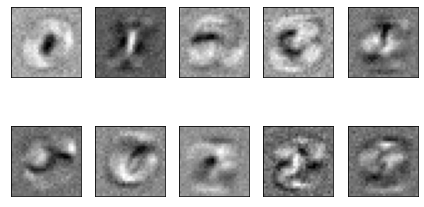

In [ ]:
nrows = 2
ncols = 5
weights_np = weights.detach().cpu().numpy()
fig, axes = plt.subplots(nrows=2, ncols=5, )

for i in range(nrows):
    for j in range(ncols):
        # axes[i, j].imshow(np.maximum(0.0, weights_np[:, i * ncols + j]).reshape((28, 28)), cmap='gray')#plt.cm.coolwarm)
        axes[i, j].imshow(weights_np[:, i * ncols + j].reshape((28, 28)), cmap='gray')#plt.cm.coolwarm)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        
plt.tight_layout()
plt.show()

The above training loop is a bit clunky and error-prone. Moreover, the code would get very messy if our model is larger and more complicated. In the following example, we will take advantage of Pytorch's built-in functionalities to build more powerful models.

# Neural Network with Pytorch

 We first introduce a helper function for evaluating neural networks.

In [ ]:
def get_test_stat(model, dl, device):
    model.eval()    # set model to eval mode
    cum_loss, cum_acc = 0.0, 0.0
    total_samples = 0

    for i, (xb, yb) in enumerate(dl):
        xb = xb.to(device)
        yb = yb.to(device)
        
        xb = xb.view(xb.size(0), -1)
        y_pred = model(xb)
        loss = loss_fn(y_pred, yb)
        acc = accuracy(y_pred, yb)
        cum_loss += loss.item() * len(yb)
        cum_acc += acc.item() * len(yb)
        total_samples += len(yb)
    
    cum_loss /= total_samples
    cum_acc /= total_samples
    model.train()   # set model back to train mode
    return cum_loss, cum_acc

Then, we build a neural network with one hidden layer, by extending the `torch.nn.Module` class. This allows us to keep the code modularized, and is how larger and more complicated models (e.g. ConvNets) are usually built in Pytorch.

In [ ]:
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()

        # define the parameters here
        self.fc = torch.nn.Linear(input_dim, hidden_dim)          # first layer
        self.out_layer = torch.nn.Linear(hidden_dim, output_dim)  # output layer
    
    def forward(self, x):   # defines the forward pass (overwriting the default method)
        out = self.fc(x)            # pass input through the first layer
        out = F.relu(out)           # apply ReLU activation
        out = self.out_layer(out)   # pass through the output layer
        
        return out

We can now train the network. Note that instead of manually updating the weights ourselves, we use a built-in Pytorch optimizer here `torch.optim.SGD`. Many other optimizers are available too (https://pytorch.org/docs/stable/optim.html).

In [ ]:
learning_rate = 1e-2
epochs = 10

dim_x = 784
dim_h = 100
dim_out = 10

# instantiate the model
model = Net(dim_x, dim_h, dim_out)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# create datasets and data loader
mnist_train = datasets.MNIST('data', train=True, download=True,
                       transform=transforms.ToTensor())

mnist_test = datasets.MNIST('../data', train=False, download=True, transform=
                            transforms.ToTensor())
train_dl = DataLoader(mnist_train, batch_size=bs)
test_dl = DataLoader(mnist_test, batch_size = 100)

# Using GPUs in PyTorch is pretty straightforward
if torch.cuda.is_available():
    print("Using cuda")
    use_cuda = True
    device = torch.device("cuda")
else:
    device = "cpu"

model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()

# set the model to training mode
model.train()

train_stats = {
    'epoch': [],
    'loss': [],
    'acc': []
}
test_stats = {
    'epoch': [],
    'loss': [],
    'acc': []
}

pbar = tqdm(range(epochs))
for epoch in pbar:
    pbar.set_description(f"Epoch {epoch + 1} / 10")
    train_loss = 0.0
    train_acc = 0.0
    for i, (xb, yb) in enumerate(train_dl):
        xb = xb.to(device)
        yb = yb.to(device)
        xb = xb.view(xb.size(0), -1)
        
        # Forward pass
        y_pred = model(xb)
        loss = loss_fn(y_pred, yb)
        acc = accuracy(y_pred, yb)
        # Backward pass
        model.zero_grad()  # Zero out the previous gradient computation
        loss.backward()    # Compute the gradient
        optimizer.step()   # Use the gradient information to make a step
        train_stats['epoch'].append(epoch + i / len(train_dl))
        train_stats['loss'].append(loss.item())
        train_stats['acc'].append(acc.item())
    
    test_loss, test_acc = get_test_stat(model, test_dl, device)
    test_stats['epoch'].append(epoch + 1)
    test_stats['loss'].append(test_loss)
    test_stats['acc'].append(test_acc)


Using cuda


  0%|          | 0/10 [00:00<?, ?it/s]

Plot training and test loss & accuracy curves.


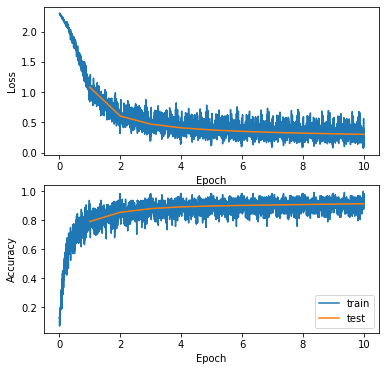

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))

axes[0].plot(train_stats['epoch'], train_stats['loss'], label='train')
axes[0].plot(test_stats['epoch'], test_stats['loss'], label='test')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

axes[1].plot(train_stats['epoch'], train_stats['acc'], label='train')
axes[1].plot(test_stats['epoch'], test_stats['acc'], label='test')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')

plt.legend()
plt.show()


## Weight visualization

We visualize the learned weights in the first layer of the network as images. Compared to the linear model before, this model has 100 hidden units with ReLU activation, enabling it to make use of a more diverse set of features.

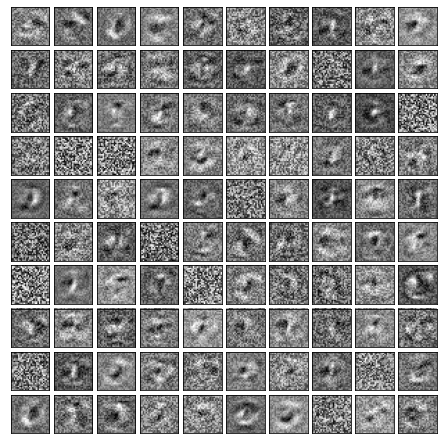

In [ ]:
nrows = 10
ncols = 10
first_layer_weights = model.fc.weight.detach().cpu().numpy()
fig, axes = plt.subplots(nrows=ncols, ncols=ncols, figsize=(6, 6))

for i in range(nrows):
    for j in range(ncols):
        axes[i, j].imshow(first_layer_weights[i * ncols + j].reshape((28, 28)), cmap='gray')
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        
plt.tight_layout(pad=0.1)
plt.show()

## [Exercise] What input activates an output class the most?
Unlike the linear model, we cannot directly visualize the weights connected to each output class. Instead, we will solve an optimization problem. Specifically, we will:

1. Choose an output class you'd like to visualize (e.g. '2'). Initialize the input to be a random image.
2. Compute the forward pass through the network.
3. Compute the gradient of the output unit w.r.t. the *input*.
4. Do a gradient ascent step on the *input*.
5. Repeat step 2-4 until a satisfactory visualization is obtained.

Optimizing the input to maximize the activation of some feature unit (in this case, an output unit) is a technique for feature visualization. This exercise only gives a naive example, and would probably not produce satisfactory visualizations on larger models and more diverse datasets (e.g. large ConvNet models on ImageNet). See [this article](https://distill.pub/2017/feature-visualization/) for techniques and fun examples of feature visualizations on GoogleNet trained on Imagenet.

  0%|          | 0/10 [00:00<?, ?it/s]

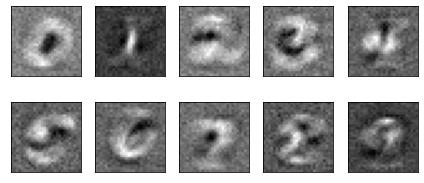

In [ ]:
input_lr = 0.01
input_train_itr = 200

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(6, 3))
pbar = tqdm(range(10))


for class_i in pbar:
    pbar.set_description(f"Visualizing class '{class_i}'")

    # 1. Initialize the input image.
    ### YOUR CODE HERE ###
    input_img = torch.normal(mean=torch.zeros((784,)), std=0.001).to(device)

    # we need to do optimization on imput_img, hence set the requires_grad flag
    input_img.requires_grad = True

    # define the gradient descent optimizer on input_img
    input_optim = torch.optim.SGD([input_img], lr=input_lr)

    for train_i in range(input_train_itr):
        # 2. Compute the forward pass through the network.
        ### YOUR CODE HERE ###
        model_out = model(input_img)
        neg_output = -1 * model_out[class_i]

        # 3. backward pass
        ### YOUR CODE HERE ###
        input_optim.zero_grad()       
        neg_output.backward()

        # 4. Do a gradient ascent step on the input
        ### YOUR CODE HERE ###
        input_optim.step()

    # plot the optimized input_img
    axes[class_i // 5, class_i % 5].imshow(input_img.detach().cpu().numpy().reshape((28, 28)), cmap='gray')
    axes[class_i // 5, class_i % 5].set_xticks([])
    axes[class_i // 5, class_i % 5].set_yticks([])

plt.tight_layout()
plt.show()